# Project: Stock Price Prediction

In [14]:
#import necessary libraries

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from transformers import TFBertModel, BertTokenizer
from keras.models import Model
from keras.layers import Input, Flatten, Dropout, concatenate
from keras.optimizers import Adam
import random

### Overall Goal

Predict stock price (closing) on day X+1 as precisely as possible.

### Data Import And Cleaning

In [6]:
#get data

path_to_df = "..\Data\SPX.csv"
df = pd.read_csv(path_to_df)

df = df[::-1].reset_index(drop=True) #reverse order

df.head()

,Date,Close/Last,Open,High,Low
0,02/24/2014,1847.61,1836.78,1858.71,1836.78
1,02/25/2014,1845.12,1847.66,1852.91,1840.19
2,02/26/2014,1845.16,1845.79,1852.65,1840.66
3,02/27/2014,1854.29,1844.90,1854.53,1841.13
4,02/28/2014,1859.45,1855.12,1867.92,1847.67


In [7]:
path_to_apple_data = "..\Data\AAPL.csv"
apple = pd.read_csv(path_to_apple_data)

apple.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.470742,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.481930,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.378824,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.367033,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.409361,447610800


In [94]:
def plot_chart(df, col, is_df=True): # Plotting the col against dates
    # Create a larger plot
    fig, ax = plt.subplots(figsize=(12, 6))
    num_args = len(col)

    for ind in range(num_args):
        if is_df:
            ax.plot(df['Date'], df[col[ind]])
        else:
            ax.plot(df['Date'], col[ind])

    ax.set_title('Plot of price over time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    # Automatically set the x-axis date labels based on available space
    ax.xaxis.set_major_locator(MaxNLocator(nbins=10))

    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout for better appearance
    plt.show()

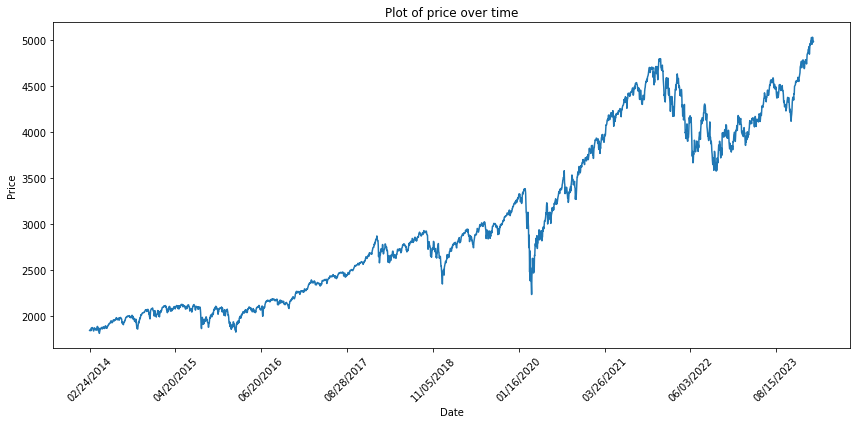

In [95]:
# plotting data

plot_chart(df, ["Close/Last"])

In [8]:
def normalize(input, scaler):
    output_norm = scaler.fit_transform(input.reshape(-1, 1))
    output_norm = output_norm.flatten()
    return output_norm

In [9]:
def denormalize(input_norm, scaler):
    output = scaler.inverse_transform(input_norm.reshape(-1, 1))
    output = output.flatten()
    return output

In [29]:
# normalizing

closing_prices = df["Close/Last"].values
apple_closing_prices = apple["Close"].values

minmax_scaler = MinMaxScaler(feature_range=(0,1))
closing_prices_norm = normalize(closing_prices, minmax_scaler)
apple_closing_prices_norm = normalize(apple_closing_prices, minmax_scaler)

In [11]:
def prep_data(feature_vec_len, data):
    features = []
    labels = []
    data_len = len(data)

    for ind in range(data_len):
        feature_vec = []
        if ind < data_len - feature_vec_len:
            for ind2 in range(feature_vec_len):
                feature = data[ind + ind2]
                feature_vec.append(feature)

            label = data[ind + ind2 + 1]
            labels.append(label)
            features.append(feature_vec)

    features = np.array(features)
    labels = np.array(labels)

    return features, labels

In [30]:
# generating feature and label vectors

feature_vec_len = 14
features_norm, labels_norm = prep_data(feature_vec_len, closing_prices_norm)

In [64]:
# splitting into sets

X_train_norm, X_temp, y_train_norm, y_temp = train_test_split(features_norm, labels_norm, test_size=0.3, random_state=42, shuffle=False)
X_test_norm, X_val_norm, y_test_norm, y_val_norm = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

shuffled_indices = np.random.permutation(len(X_train_norm))

X_train_norm = X_train_norm[shuffled_indices]
y_train_norm = y_train_norm[shuffled_indices]

### 1. Linear Regression

In [ ]:
#Technique 1: Linear Regression
#fit model to the last X (Hyperparam) days
#use model to predict price on day X+1
#eval

In [65]:
def fit_lin_reg(feature_vec_len, features_norm):
    linear_regressor = LinearRegression()
    days = np.arange(feature_vec_len).reshape(-1, 1)
    lin_reg_predictions = []

    for feature in features_norm:
        linear_regressor.fit(days, feature)
        pred = linear_regressor.predict(np.array(feature_vec_len + 1).reshape(-1, 1))
        lin_reg_predictions.append(pred[0])

    return np.array(lin_reg_predictions)

In [66]:
# fit models to every feature vector (split is not needed here)
lin_reg_predictions_norm = fit_lin_reg(feature_vec_len, features_norm)

In [67]:
def eval(predictions, labels):
    mae = mean_absolute_error(labels, predictions) #add feature_vec_len: to remove leading zeros
    mape = np.mean(np.abs((labels - predictions) / labels)) * 100

    return mae, mape

In [78]:
# eval

lin_reg_predictions = denormalize(lin_reg_predictions_norm, minmax_scaler)
labels = denormalize(labels_norm, minmax_scaler)

mae, mape = eval(lin_reg_predictions, labels)

print(f"MAE: {round(mae, 3)}")
print(f"MAPE: {round(mape, 3)}%")

MAE: 2.207
MAPE: 4.02%


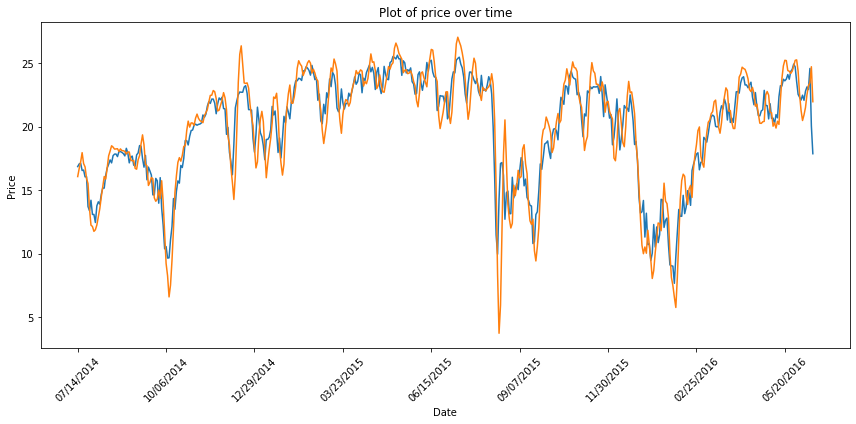

In [ ]:
# plotting

start = 100
end = 600

plot_chart(df[start:end], [labels[start:end], lin_reg_predictions[start:end]], is_df=False)

In [ ]:
# optimal feature vec len search

MAE_errors = []
MAPE_errors = []

for feature_vec_len in tqdm(range(1,30)):
    features_norm, labels_norm = prep_data(feature_vec_len, closing_prices_norm)
    lin_reg_predictions_norm = fit_lin_reg(feature_vec_len, features_norm)

    lin_reg_predictions = denormalize(lin_reg_predictions_norm, minmax_scaler)
    labels = denormalize(labels_norm, minmax_scaler)

    mae, mape = eval(lin_reg_predictions, labels)

    MAE_errors.append(mae)
    MAPE_errors.append(mape)

100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


Lowest MAE is 1.337, with feature vec len = 1 (just copies close from prev day)
Lowest MAPE is 2.401%, with feature vec len = 1 (just copies close from prev day)


Lowest MAE is 2.057, with non-trivial feature vec len = 6
Lowest MAPE is 3.619%, with non-trivial feature vec len = 6


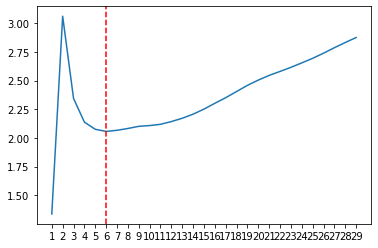

In [ ]:
x_values = np.arange(1, len(MAE_errors) + 1)
plt.plot(x_values, MAE_errors)
plt.xticks(np.arange(1, len(MAE_errors) + 1, 1))

best_feat_vec_len_MAE, best_MAE = min(enumerate(MAE_errors), key=lambda x: x[1])
print(f"Lowest MAE is {round(best_MAE, 3)}, with feature vec len = {best_feat_vec_len_MAE + 1} (just copies close from prev day)")

best_feat_vec_len_MAPE, best_MAPE = min(enumerate(MAPE_errors), key=lambda x: x[1])
print(f"Lowest MAPE is {round(best_MAPE, 3)}%, with feature vec len = {best_feat_vec_len_MAPE + 1} (just copies close from prev day)")

MAE_errors_copy = MAE_errors.copy()
MAPE_errors_copy = MAPE_errors.copy()

print("\n")

MAE_errors_copy[best_feat_vec_len_MAE] = 1000000
MAPE_errors_copy[best_feat_vec_len_MAPE] = 1000000

sec_best_feat_vec_len_MAE, sec_best_MAE = min(enumerate(MAE_errors_copy), key=lambda x: x[1])
print(f"Lowest MAE is {round(sec_best_MAE, 3)}, with non-trivial feature vec len = {sec_best_feat_vec_len_MAE + 1}")

sec_best_feat_vec_len_MAPE, sec_best_MAPE = min(enumerate(MAPE_errors_copy), key=lambda x: x[1])
print(f"Lowest MAPE is {round(sec_best_MAPE, 3)}%, with non-trivial feature vec len = {sec_best_feat_vec_len_MAPE + 1}")

plt.axvline(x=sec_best_feat_vec_len_MAE + 1, color='red', linestyle='--')

In [ ]:
# How much does the price change from day to day on average?
print(closing_prices)
percentage_changes = ((closing_prices[1:] - closing_prices[:-1]) / closing_prices[:-1]) * 100

# Calculate the average percentage change
average_percentage_change = np.mean(percentage_changes)

print(f"Average change in closing price from day to day: {round(average_percentage_change, 3)}%") #modelle die schlechter sind als das sind komplett nutzlos

[1847.61 1845.12 1845.16 ... 5005.57 4975.51 4981.8 ]
Average change in closing price from day to day: 0.045%


Can I find a method that is better than just copying the value from the previous day?

### 2. Multilayer Perceptron

In [86]:
def create_model(feature_vec_len):
    mlp_model = Sequential()
    mlp_model.add(Dense(units=128, input_dim=feature_vec_len, activation='relu'))
    mlp_model.add(Dense(units=64, activation='relu'))
    mlp_model.add(Dense(units=32, activation='relu'))
    mlp_model.add(Dense(units=16, activation='relu'))
    mlp_model.add(Dense(units=8, activation='relu'))
    mlp_model.add(Dense(units=4, activation='relu'))
    mlp_model.add(Dense(units=1, activation='linear'))

    mlp_model.compile(optimizer='adam', loss='mae')
    return mlp_model

In [87]:
# init model

mlp_model = create_model(feature_vec_len)
print(mlp_model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1920      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 4)                 36        
                                                                 
 dense_6 (Dense)             (None, 1)                

In [88]:
def train(model, X_train, y_train):
    history = model.fit(X_train, y_train, epochs=50, batch_size=1, validation_data=(X_val_norm, y_val_norm), verbose=1)
    return history

In [89]:
# training

history = train(mlp_model, X_train_norm, y_train_norm)

Epoch 1/50

1761/1761 [==============================] - 5s 2ms/step - loss: 0.0235 - val_loss: 0.0284
Epoch 2/50
1761/1761 [==============================] - 3s 2ms/step - loss: 0.0145 - val_loss: 0.0414
Epoch 3/50
1761/1761 [==============================] - 3s 2ms/step - loss: 0.0132 - val_loss: 0.0217
Epoch 4/50
1761/1761 [==============================] - 3s 2ms/step - loss: 0.0119 - val_loss: 0.0158
Epoch 5/50
1761/1761 [==============================] - 4s 2ms/step - loss: 0.0111 - val_loss: 0.0192
Epoch 6/50
1761/1761 [==============================] - 3s 2ms/step - loss: 0.0109 - val_loss: 0.0172
Epoch 7/50
1761/1761 [==============================] - 3s 2ms/step - loss: 0.0107 - val_loss: 0.0169
Epoch 8/50
1761/1761 [==============================] - 3s 2ms/step - loss: 0.0108 - val_loss: 0.0314
Epoch 9/50
1761/1761 [==============================] - 3s 2ms/step - loss: 0.0107 - val_loss: 0.0249
Epoch 10/50
1761/1761 [==============================] - 3s 2ms/step - loss: 0.01

In [90]:
def plot_loss(history, training=True):
    if training:
        training_loss = history.history["loss"]
        plt.plot(training_loss)
        plt.title('Training Loss Over Epochs')
    else:
        validation_loss = history.history["val_loss"]
        plt.plot(validation_loss)
        plt.title('Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Average Error Loss')
    plt.show()

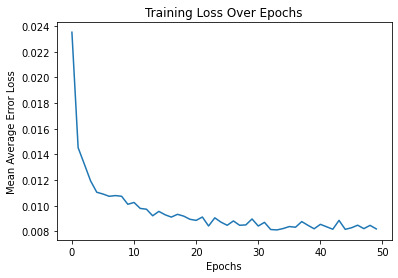

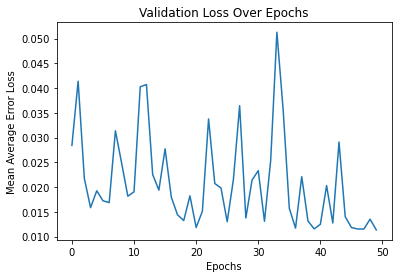

In [91]:
# plotting training loss

plot_loss(history)
plot_loss(history, training=False)

In [92]:
# eval

mlp_predictions_norm = mlp_model.predict(X_test_norm)

#todo denormalize
mlp_predictions = denormalize(mlp_predictions_norm, minmax_scaler)
y_test = denormalize(y_test_norm, minmax_scaler)

mae, mape = eval(mlp_predictions, y_test)

print(f"MAE: {round(mae, 3)}")
print(f"MAPE: {round(mape, 3)}%")

12/12 [==============================] - 0s 1ms/step
MAE: 2.403
MAPE: 1.596%


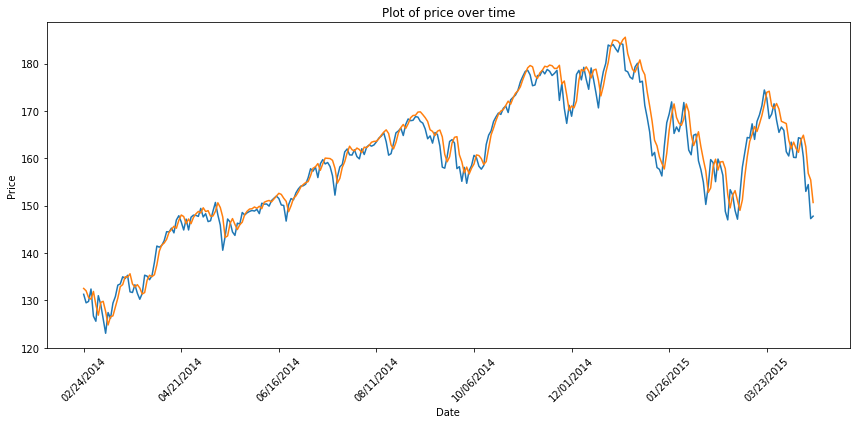

In [96]:
# plotting

start = 0
end = 300

plot_chart(df[start:end], [y_test[start:end], mlp_predictions[start:end]], is_df=False)

In [ ]:
# optimal feature vec len search

MAE_errors = []
MAPE_errors = []

for feature_vec_len in tqdm(range(1,30)):
    features_norm, labels_norm = prep_data(feature_vec_len, closing_prices_norm)
    lin_reg_predictions_norm = fit_lin_reg(feature_vec_len, features_norm)

    X_train_norm, X_temp, y_train_norm, y_temp = train_test_split(features_norm, labels_norm, test_size=0.3, random_state=42, shuffle=False)
    X_test_norm, X_val_norm, y_test_norm, y_val_norm = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)
    shuffled_indices = np.random.permutation(len(X_train_norm))
    X_train_norm = X_train_norm[shuffled_indices]
    y_train_norm = y_train_norm[shuffled_indices]

    mlp_model = create_model(feature_vec_len)
    history = train(mlp_model, X_train_norm, y_train_norm)

    mlp_predictions_norm = mlp_model.predict(X_test_norm)

    mlp_predictions = denormalize(mlp_predictions_norm, minmax_scaler)
    y_test = denormalize(y_test_norm, minmax_scaler)

    mae, mape = eval(mlp_predictions, y_test)

    MAE_errors.append(mae)
    MAPE_errors.append(mape)

  0%|          | 0/29 [00:00<?, ?it/s]

12/12 [==============================] - 0s 2ms/step


  3%|▎         | 1/29 [01:15<35:03, 75.13s/it]

12/12 [==============================] - 0s 2ms/step


  7%|▋         | 2/29 [02:26<32:46, 72.84s/it]

12/12 [==============================] - 0s 2ms/step


 10%|█         | 3/29 [03:37<31:10, 71.93s/it]

12/12 [==============================] - 0s 2ms/step


 14%|█▍        | 4/29 [04:48<29:50, 71.61s/it]

12/12 [==============================] - 0s 2ms/step


 17%|█▋        | 5/29 [05:59<28:31, 71.31s/it]

12/12 [==============================] - 0s 2ms/step


 21%|██        | 6/29 [07:10<27:23, 71.45s/it]

12/12 [==============================] - 0s 3ms/step


 24%|██▍       | 7/29 [08:22<26:11, 71.43s/it]

12/12 [==============================] - 0s 2ms/step


 28%|██▊       | 8/29 [09:37<25:28, 72.77s/it]

12/12 [==============================] - 0s 2ms/step


 31%|███       | 9/29 [10:53<24:32, 73.63s/it]

12/12 [==============================] - 0s 3ms/step


 34%|███▍      | 10/29 [12:09<23:33, 74.41s/it]

12/12 [==============================] - 0s 2ms/step


 38%|███▊      | 11/29 [13:24<22:20, 74.45s/it]

12/12 [==============================] - 0s 2ms/step


 41%|████▏     | 12/29 [14:38<21:05, 74.43s/it]

12/12 [==============================] - 0s 2ms/step


 45%|████▍     | 13/29 [15:50<19:40, 73.78s/it]

12/12 [==============================] - 0s 2ms/step


 48%|████▊     | 14/29 [17:00<18:10, 72.68s/it]

12/12 [==============================] - 0s 2ms/step


 52%|█████▏    | 15/29 [18:09<16:40, 71.45s/it]

12/12 [==============================] - 0s 2ms/step


 55%|█████▌    | 16/29 [19:18<15:18, 70.66s/it]

12/12 [==============================] - 0s 2ms/step


 59%|█████▊    | 17/29 [20:27<14:03, 70.26s/it]

12/12 [==============================] - 0s 2ms/step


 62%|██████▏   | 18/29 [21:36<12:49, 69.93s/it]

12/12 [==============================] - 0s 2ms/step


 66%|██████▌   | 19/29 [22:49<11:49, 70.90s/it]

12/12 [==============================] - 0s 3ms/step


 69%|██████▉   | 20/29 [24:04<10:48, 72.02s/it]

12/12 [==============================] - 0s 2ms/step


 72%|███████▏  | 21/29 [25:21<09:46, 73.36s/it]

12/12 [==============================] - 0s 3ms/step


 76%|███████▌  | 22/29 [26:35<08:34, 73.54s/it]

12/12 [==============================] - 0s 2ms/step


 79%|███████▉  | 23/29 [27:49<07:23, 73.87s/it]

12/12 [==============================] - 0s 2ms/step


 83%|████████▎ | 24/29 [29:04<06:10, 74.19s/it]

12/12 [==============================] - 0s 2ms/step


 86%|████████▌ | 25/29 [30:20<04:58, 74.59s/it]

12/12 [==============================] - 0s 2ms/step


 90%|████████▉ | 26/29 [31:35<03:44, 74.90s/it]

12/12 [==============================] - 0s 2ms/step


 93%|█████████▎| 27/29 [32:50<02:29, 74.93s/it]

12/12 [==============================] - 0s 2ms/step


 97%|█████████▋| 28/29 [34:05<01:14, 74.82s/it]

12/12 [==============================] - 0s 2ms/step


100%|██████████| 29/29 [35:21<00:00, 73.14s/it]


Lowest MAE is 38.905, with feature vec len = 5
Lowest MAPE is 0.916%, with feature vec len = 5


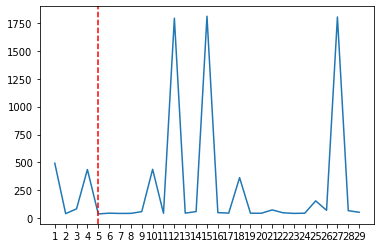

In [ ]:
x_values = np.arange(1, len(MAE_errors) + 1)
plt.plot(x_values, MAE_errors)
plt.xticks(np.arange(1, len(MAE_errors) + 1, 1))

best_feat_vec_len_MAE, best_MAE = min(enumerate(MAE_errors), key=lambda x: x[1])
print(f"Lowest MAE is {round(best_MAE, 3)}, with feature vec len = {best_feat_vec_len_MAE + 1}")

best_feat_vec_len_MAPE, best_MAPE = min(enumerate(MAPE_errors), key=lambda x: x[1])
print(f"Lowest MAPE is {round(best_MAPE, 3)}%, with feature vec len = {best_feat_vec_len_MAPE + 1}")

plt.axvline(x=best_feat_vec_len_MAE + 1, color='red', linestyle='--', label='X=5')

### 3. LSTM

In [ ]:
# init model

lstm_model = Sequential()
lstm_model.add(LSTM(units=64, input_shape=(feature_vec_len, 1), activation='relu', return_sequences=True))
lstm_model.add(LSTM(units=32, activation='relu'))
lstm_model.add(Dense(units=16, activation='relu'))
lstm_model.add(Dense(units=8, activation='relu'))
lstm_model.add(Dense(units=1, activation='linear'))
lstm_model.compile(optimizer='adam', loss='mean_absolute_error')
print(lstm_model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 64)            16896     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_65 (Dense)            (None, 16)                528       
                                                                 
 dense_66 (Dense)            (None, 8)                 136       
                                                                 
 dense_67 (Dense)            (None, 1)                 9         
                                                                 
Total params: 29985 (117.13 KB)
Trainable params: 29985 (117.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# train

lstm_history = train(lstm_model, X_train_norm, y_train_norm)

Epoch 1/50
1761/1761 [==============================] - 13s 6ms/step - loss: 0.0232 - val_loss: 0.0261
Epoch 2/50
1761/1761 [==============================] - 10s 6ms/step - loss: 0.0164 - val_loss: 0.0333
Epoch 3/50
1761/1761 [==============================] - 10s 6ms/step - loss: 0.0152 - val_loss: 0.0177
Epoch 4/50
1761/1761 [==============================] - 11s 6ms/step - loss: 0.0135 - val_loss: 0.0206
Epoch 5/50
1761/1761 [==============================] - 10s 6ms/step - loss: 0.0128 - val_loss: 0.0137
Epoch 6/50
1761/1761 [==============================] - 10s 6ms/step - loss: 0.0106 - val_loss: 0.0175
Epoch 7/50
1761/1761 [==============================] - 10s 6ms/step - loss: 0.0107 - val_loss: 0.0237
Epoch 8/50
1761/1761 [==============================] - 10s 6ms/step - loss: 0.0110 - val_loss: 0.0176
Epoch 9/50
1761/1761 [==============================] - 11s 6ms/step - loss: 0.0100 - val_loss: 0.0130
Epoch 10/50
1761/1761 [==============================] - 10s 6ms/step - l

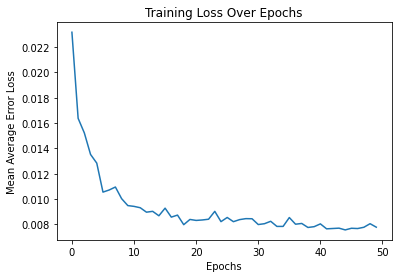

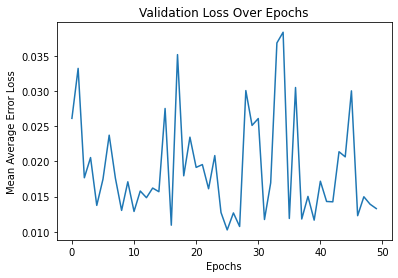

In [ ]:
# plotting training loss

plot_loss(lstm_history)
plot_loss(lstm_history, training=False)

In [ ]:
# eval

lstm_predictions_norm = lstm_model.predict(X_test_norm)

#todo denormalize
lstm_predictions = denormalize(lstm_predictions_norm, minmax_scaler)
y_test = denormalize(y_test_norm, minmax_scaler)

mae, mape = eval(lstm_predictions, y_test)

print(f"MAE: {round(mae, 3)}")
print(f"MAPE: {round(mape, 3)}%")

12/12 [==============================] - 0s 4ms/step
MAE: 2.666
MAPE: 1.787%


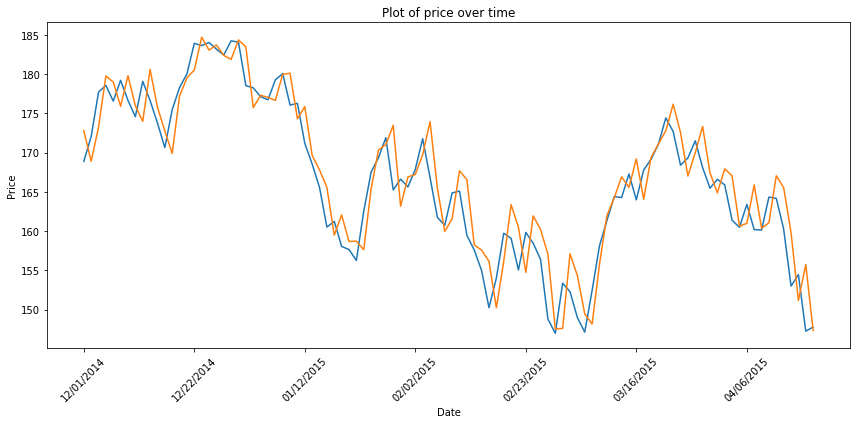

In [ ]:
# plotting

start = 200
end = 300

plot_chart(df[start:end], [y_test[start:end], lstm_predictions[start:end]], is_df=False)

In [ ]:
# optimal feature vec len search

MAE_errors = []
MAPE_errors = []

for feature_vec_len in tqdm(range(1,30)):
    features_norm, labels_norm = prep_data(feature_vec_len, closing_prices_norm)
    lin_reg_predictions_norm = fit_lin_reg(feature_vec_len, features_norm)

    X_train_norm, X_temp, y_train_norm, y_temp = train_test_split(features_norm, labels_norm, test_size=0.3, random_state=42, shuffle=False)
    X_test_norm, X_val_norm, y_test_norm, y_val_norm = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)
    shuffled_indices = np.random.permutation(len(X_train_norm))
    X_train_norm = X_train_norm[shuffled_indices]
    y_train_norm = y_train_norm[shuffled_indices]

    lstm_model = create_model(feature_vec_len)
    history = train(lstm_model, X_train_norm, y_train_norm)

    lstm_predictions_norm = lstm_model.predict(X_test_norm)

    lstm_predictions = denormalize(lstm_predictions_norm, minmax_scaler)
    y_test = denormalize(y_test_norm, minmax_scaler)

    mae, mape = eval(lstm_predictions, y_test)

    MAE_errors.append(mae)
    MAPE_errors.append(mape)

  0%|          | 0/29 [00:00<?, ?it/s]

12/12 [==============================] - 0s 4ms/step


  3%|▎         | 1/29 [02:27<1:08:47, 147.41s/it]

12/12 [==============================] - 0s 1ms/step


  7%|▋         | 2/29 [04:43<1:03:23, 140.86s/it]

12/12 [==============================] - 0s 2ms/step


 10%|█         | 3/29 [06:54<58:59, 136.13s/it]  

12/12 [==============================] - 0s 1ms/step


 14%|█▍        | 4/29 [08:59<54:59, 131.99s/it]

12/12 [==============================] - 0s 1ms/step


 17%|█▋        | 5/29 [11:13<53:03, 132.66s/it]

12/12 [==============================] - 0s 1ms/step


 21%|██        | 6/29 [13:19<49:57, 130.31s/it]

12/12 [==============================] - 0s 1ms/step


 24%|██▍       | 7/29 [15:12<45:40, 124.59s/it]

12/12 [==============================] - 0s 1ms/step


 28%|██▊       | 8/29 [17:03<42:09, 120.44s/it]

12/12 [==============================] - 0s 1ms/step


 31%|███       | 9/29 [18:57<39:23, 118.20s/it]

12/12 [==============================] - 0s 1ms/step


 34%|███▍      | 10/29 [20:51<37:05, 117.16s/it]

12/12 [==============================] - 0s 2ms/step


 38%|███▊      | 11/29 [23:17<37:46, 125.91s/it]

12/12 [==============================] - 0s 1ms/step


 41%|████▏     | 12/29 [25:44<37:26, 132.15s/it]

12/12 [==============================] - 0s 4ms/step


 45%|████▍     | 13/29 [29:29<42:45, 160.36s/it]

12/12 [==============================] - 0s 6ms/step


 48%|████▊     | 14/29 [34:02<48:34, 194.29s/it]

12/12 [==============================] - 0s 6ms/step


 52%|█████▏    | 15/29 [38:37<51:03, 218.84s/it]

12/12 [==============================] - 0s 6ms/step


 55%|█████▌    | 16/29 [42:13<47:11, 217.82s/it]

12/12 [==============================] - 0s 4ms/step


 59%|█████▊    | 17/29 [46:04<44:21, 221.81s/it]

12/12 [==============================] - 0s 5ms/step


 62%|██████▏   | 18/29 [50:41<43:41, 238.31s/it]

12/12 [==============================] - 0s 2ms/step


 66%|██████▌   | 19/29 [54:59<40:44, 244.45s/it]

12/12 [==============================] - 0s 3ms/step


 69%|██████▉   | 20/29 [59:01<36:31, 243.53s/it]

12/12 [==============================] - 0s 1ms/step


 72%|███████▏  | 21/29 [1:02:01<29:57, 224.64s/it]

12/12 [==============================] - 0s 1ms/step


 76%|███████▌  | 22/29 [1:04:22<23:16, 199.47s/it]

12/12 [==============================] - 0s 1ms/step


 79%|███████▉  | 23/29 [1:06:20<17:30, 175.13s/it]

12/12 [==============================] - 0s 1ms/step


 83%|████████▎ | 24/29 [1:08:17<13:07, 157.54s/it]

12/12 [==============================] - 0s 1ms/step


 86%|████████▌ | 25/29 [1:10:13<09:39, 144.98s/it]

12/12 [==============================] - 0s 1ms/step


 90%|████████▉ | 26/29 [1:12:08<06:48, 136.22s/it]

12/12 [==============================] - 0s 1ms/step


 93%|█████████▎| 27/29 [1:14:03<04:19, 129.86s/it]

12/12 [==============================] - 0s 1ms/step


 97%|█████████▋| 28/29 [1:15:59<02:05, 125.48s/it]

12/12 [==============================] - 0s 1ms/step


100%|██████████| 29/29 [1:17:54<00:00, 161.19s/it]


Lowest MAE is 2.283, with feature vec len = 1
Lowest MAPE is 1.516%, with feature vec len = 1


Second lowest MAE is 2.424, with non-trivial feature vec len = 3
Second lowest MAPE is 1.6%, with non-trivial feature vec len = 3


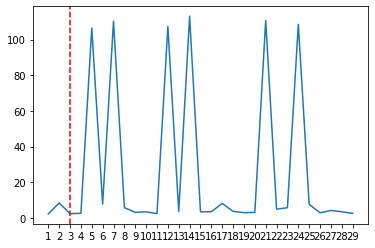

In [ ]:
x_values = np.arange(1, len(MAE_errors) + 1)
plt.plot(x_values, MAE_errors)
plt.xticks(np.arange(1, len(MAE_errors) + 1, 1))

best_feat_vec_len_MAE, best_MAE = min(enumerate(MAE_errors), key=lambda x: x[1])
print(f"Lowest MAE is {round(best_MAE, 3)}, with feature vec len = {best_feat_vec_len_MAE + 1}")

best_feat_vec_len_MAPE, best_MAPE = min(enumerate(MAPE_errors), key=lambda x: x[1])
print(f"Lowest MAPE is {round(best_MAPE, 3)}%, with feature vec len = {best_feat_vec_len_MAPE + 1}")

MAE_errors_copy = MAE_errors.copy()
MAPE_errors_copy = MAPE_errors.copy()

print("\n")

MAE_errors_copy[best_feat_vec_len_MAE] = 1000000
MAPE_errors_copy[best_feat_vec_len_MAPE] = 1000000

sec_best_feat_vec_len_MAE, sec_best_MAE = min(enumerate(MAE_errors_copy), key=lambda x: x[1])
print(f"Second lowest MAE is {round(sec_best_MAE, 3)}, with non-trivial feature vec len = {sec_best_feat_vec_len_MAE + 1}")

sec_best_feat_vec_len_MAPE, sec_best_MAPE = min(enumerate(MAPE_errors_copy), key=lambda x: x[1])
print(f"Second lowest MAPE is {round(sec_best_MAPE, 3)}%, with non-trivial feature vec len = {sec_best_feat_vec_len_MAPE + 1}")

plt.axvline(x=sec_best_feat_vec_len_MAE + 1, color='red', linestyle='--')

### 4. Transformer

In [15]:
# model

input_layer = Input(shape=(feature_vec_len,), dtype=tf.int32)
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
bert_output = bert_model(input_layer)[0]
flat_layer = Flatten()(bert_output)
dropout_layer = Dropout(0.1)(flat_layer)
output_layer = Dense(1, activation="linear")(dropout_layer)
transformer_model = Model(inputs=input_layer, outputs=output_layer)
transformer_model.compile(optimizer=Adam(lr=1e-5), loss="mae")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [19]:
# train

transformer_history = train(transformer_model, X_train_norm, y_train_norm)

Epoch 1/50


1761/1761 [==============================] - 128s 49ms/step - loss: 0.9012 - val_loss: 1.2535
Epoch 2/50
1761/1761 [==============================] - 84s 48ms/step - loss: 0.3506 - val_loss: 0.7047
Epoch 3/50
1761/1761 [==============================] - 84s 47ms/step - loss: 0.2161 - val_loss: 0.5776
Epoch 4/50
1761/1761 [==============================] - 84s 48ms/step - loss: 0.1945 - val_loss: 0.4217
Epoch 5/50
1761/1761 [==============================] - 85s 48ms/step - loss: 0.1779 - val_loss: 0.5583
Epoch 6/50
1761/1761 [==============================] - 83s 47ms/step - loss: 0.1758 - val_loss: 0.3977
Epoch 7/50
1761/1761 [==============================] - 84s 47ms/step - loss: 0.1641 - val_loss: 0.6089
Epoch 8/50
1761/1761 [==============================] - 85s 48ms/step - loss: 0.1639 - val_loss: 0.5873
Epoch 9/50
1761/1761 [==============================] - 84s 48ms/step - loss: 0.1546 - val_loss: 0.6298
Epoch 10/50
1761/1761 [==============================] - 87s 49ms/step - l

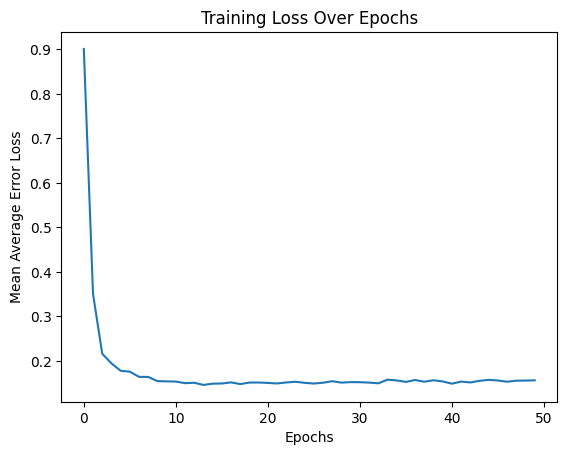

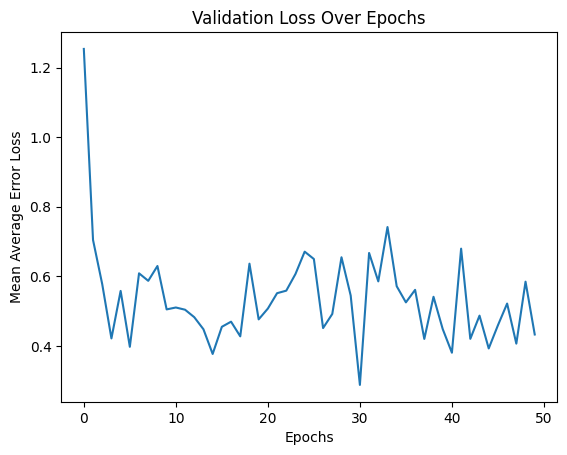

In [20]:
# plotting training loss

plot_loss(transformer_history)
plot_loss(transformer_history, training=False)

In [23]:
# eval

transformer_predictions_norm = transformer_model.predict(X_test_norm)

#todo denormalize
transformer_predictions = denormalize(transformer_predictions_norm, minmax_scaler)
y_test = denormalize(y_test_norm, minmax_scaler)

mae, mape = eval(transformer_predictions, y_test)

print(f"MAE: {round(mae, 3)}")
print(f"MAPE: {round(mape, 3)}%")

12/12 [==============================] - 1s 58ms/step
MAE: 86.067
MAPE: 55.318%


### 6. Brain

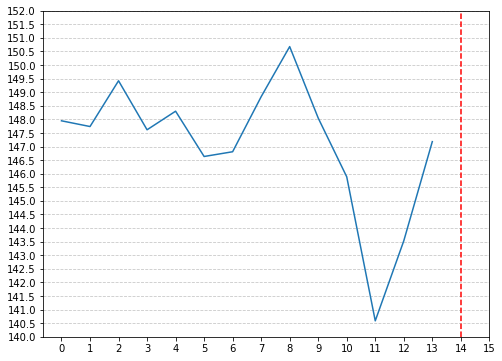

[147.94679015 147.73614286 149.41953599 147.61653805 148.30024915
 146.63411244 146.80846175 148.83341289 150.67687415 148.0485435
 145.88673112 140.5872263  143.53033778 147.18096231]
[146.55259076]




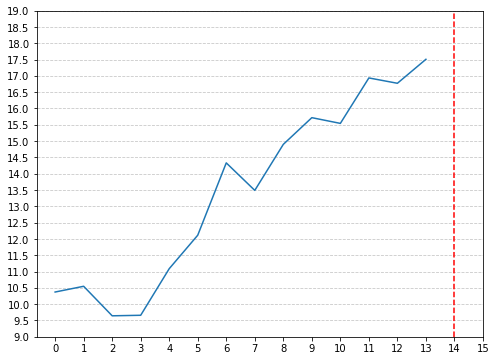

[10.3726923  10.54882675  9.64375749  9.65982381 11.08794099 12.11440021
 14.33214717 13.48896299 14.89982375 15.71861093 15.54307153 16.93667587
 16.77303744 17.50792274]
[18.90033699]




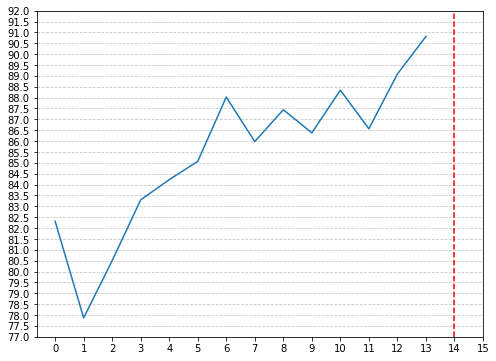

[82.31528513 77.86967538 80.49919613 83.29890084 84.22539186 85.06738594
 88.02537364 85.97840569 87.44341589 86.37887355 88.34193962 86.56750403
 89.08456055 90.81258233]
[90.15862367]




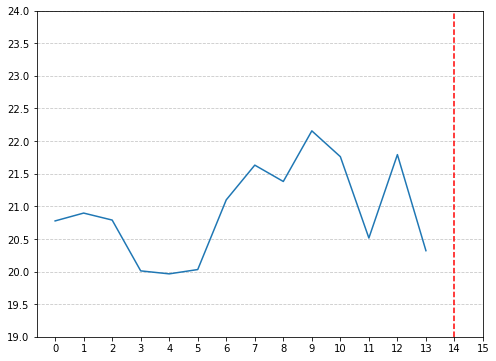

[20.77652593 20.89672579 20.789617   20.01069809 19.96487933 20.03092975
 21.09963744 21.63161109 21.38109553 22.1570392  21.76133173 20.5141094
 21.79286932 20.32012348]
[20.65870626]




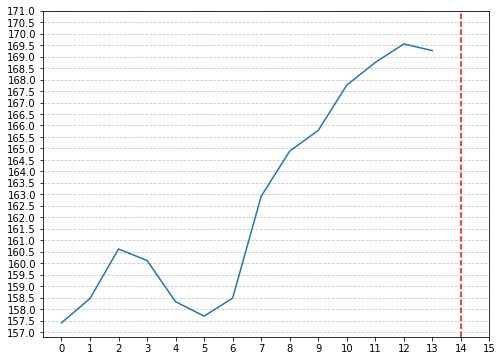

[157.40806644 158.46903849 160.62371028 160.12267917 158.32860697
 157.70142551 158.48391471 162.91464825 164.8848549  165.78278358
 167.75656052 168.74196138 169.55063273 169.2602489 ]
[170.54436426]




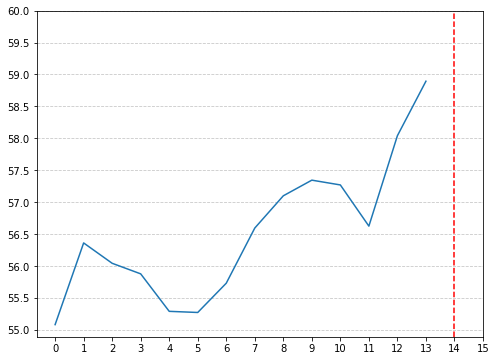

[55.08049554 56.36044556 56.04149939 55.87607582 55.28876263 55.27091117
 55.72969381 56.5937047  57.09890115 57.34406127 57.26908511 56.62405219
 58.04026839 58.89416345]
[58.37706602]




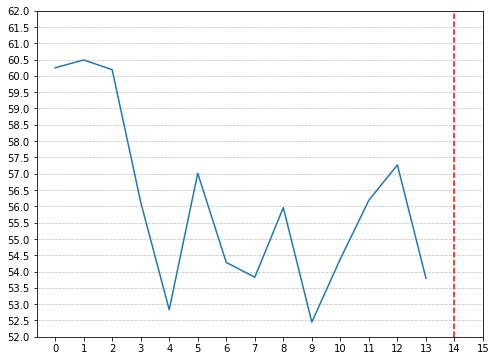

[60.24849457 60.4877042  60.18958474 56.12897157 52.83061594 57.01321412
 54.28015487 53.82672767 55.9611678  52.45097479 54.38904881 56.18847645
 57.26849006 53.79519008]
[54.31228751]




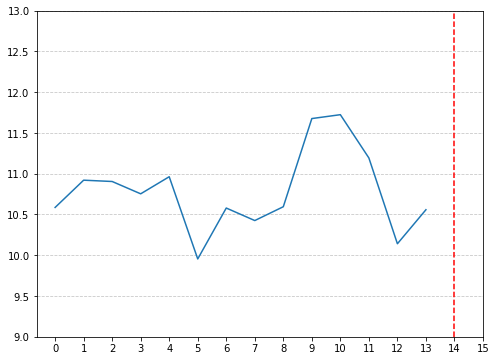

[10.58631483 10.92073227 10.90466595 10.75352355 10.96298073  9.95496803
 10.57917424 10.42565165 10.59524056 11.67644427 11.72404818 11.19326463
 10.14121831 10.55834753]
[10.98797278]




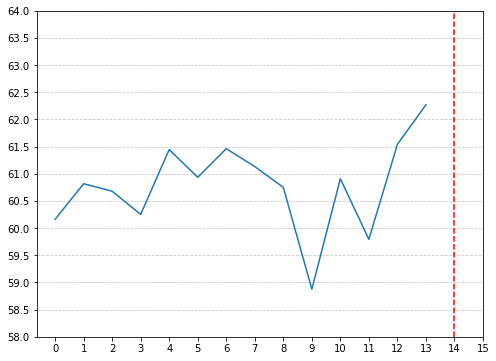

[60.16102239 60.81617115 60.67752477 60.25146982 61.44394766 60.93399082
 61.46060902 61.13154703 60.74893063 58.87631199 60.90840372 59.79328222
 61.53975052 62.26868533]
[62.38352975]




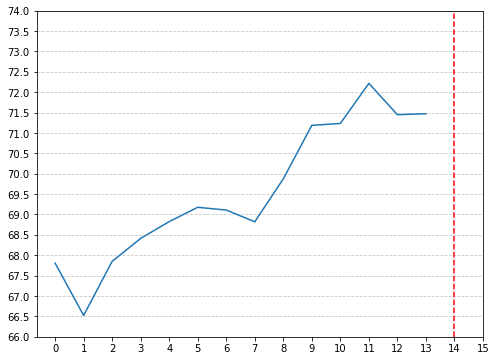

[67.80799482 66.52328441 67.85143339 68.41315948 68.82493326 69.17660712
 69.10877155 68.82076792 69.87459939 71.18668204 71.23309585 72.21611651
 71.44790847 71.47111538]
[71.18549194]




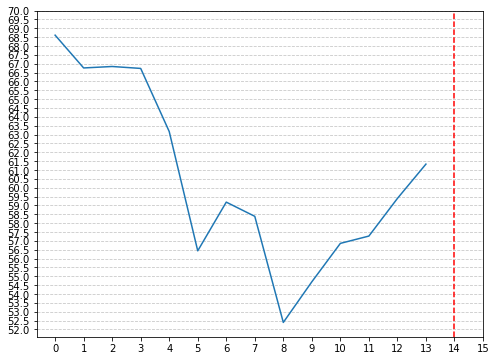

[68.61547608 66.76487424 66.84699097 66.73809704 63.17672983 56.4413722
 59.19049776 58.38837195 52.3986105  54.69252371 56.86147667 57.27444055
 59.3981698  61.33624382]
[61.3969388]




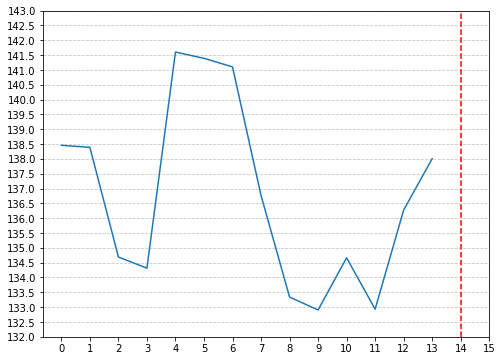

[138.45814161 138.39030605 134.69029246 134.31481666 141.60297464
 141.39232736 141.10253858 136.76701286 133.34072173 132.9039559
 134.66470536 132.93132814 136.27431243 138.00530946]
[136.55755567]




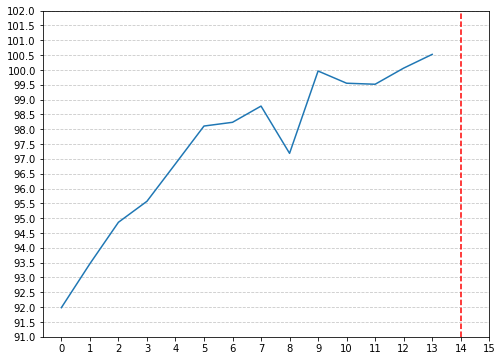

[ 91.98244832  93.46411989  94.86188957  95.56999767  96.83507147
  98.1078809   98.23403126  98.78088112  97.18734038  99.96383818
  99.5520644   99.51755157 100.06142619 100.52496922]
[99.63656133]




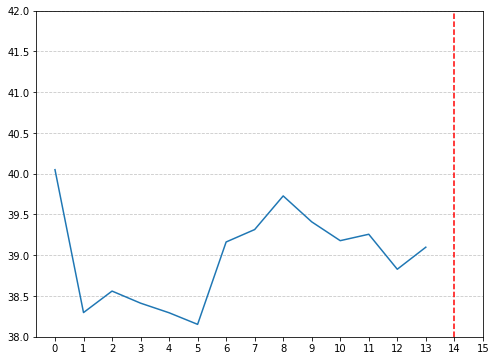

[40.04956227 38.29714348 38.56075011 38.41258295 38.29476329 38.15254662
 39.16293952 39.31527202 39.72764085 39.40988478 39.17900584 39.25755228
 38.82852208 39.09867425]
[38.98263973]




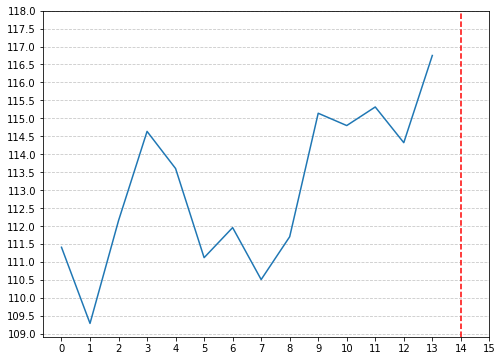

[111.40722211 109.28587305 112.15043809 114.63536197 113.60116712
 111.11743333 111.95526207 110.50750828 111.70058118 115.14115347
 114.79840535 115.31609783 114.32117619 116.75016549]
[117.14051752]




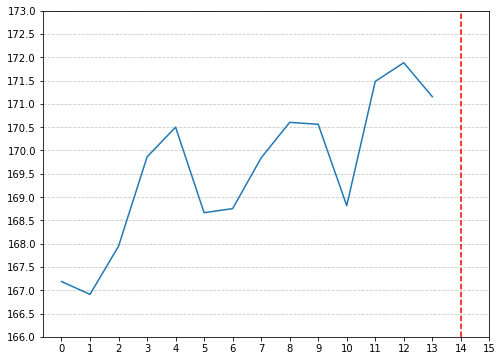

[167.1859087  166.91099615 167.94459595 169.86005811 170.49914055
 168.66341493 168.75088711 169.83982645 170.60267905 170.56043058
 168.81455733 171.48156616 171.88203402 171.15428931]
[167.38525006]




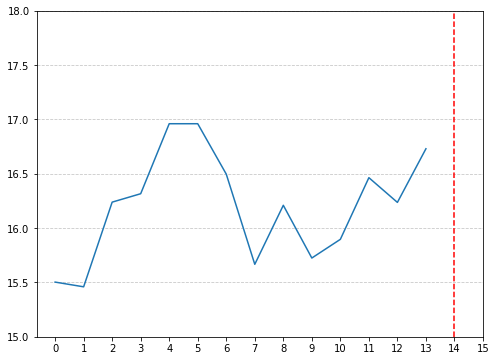

[15.50320326 15.45976469 16.2386836  16.31603995 16.95988278 16.95988278
 16.49633974 15.66684168 16.20952621 15.72456142 15.89653053 16.46361206
 16.23630341 16.72959888]
[15.33420939]




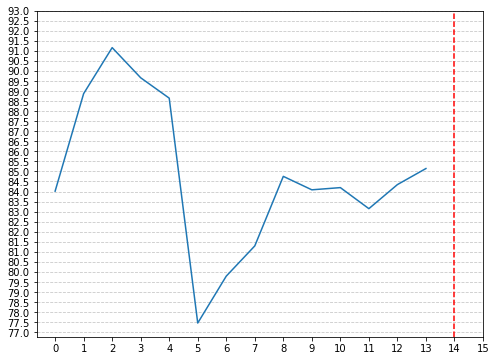

[84.01652972 88.87093802 91.1594958  89.65937771 88.64541452 77.45611644
 79.78930288 81.29358631 84.75379521 84.08436529 84.19444932 83.14716339
 84.34440162 85.14355219]
[80.32603692]




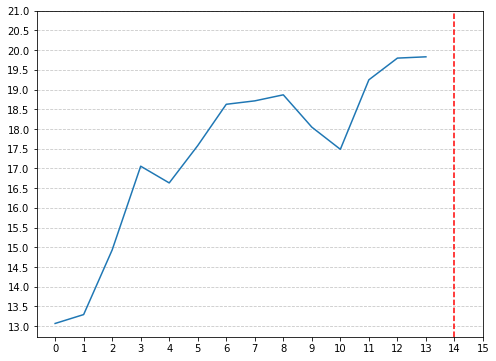

[13.06766842 13.29319193 14.93195639 17.05568564 16.63141582 17.5781385
 18.62542443 18.71230156 18.86522911 18.04584688 17.48352574 19.24606035
 19.79648052 19.8292082 ]
[19.65723909]




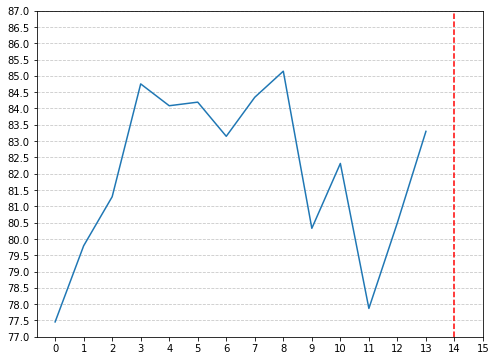

[77.45611644 79.78930288 81.29358631 84.75379521 84.08436529 84.19444932
 83.14716339 84.34440162 85.14355219 80.32603692 82.31528513 77.86967538
 80.49919613 83.29890084]
[84.22539186]




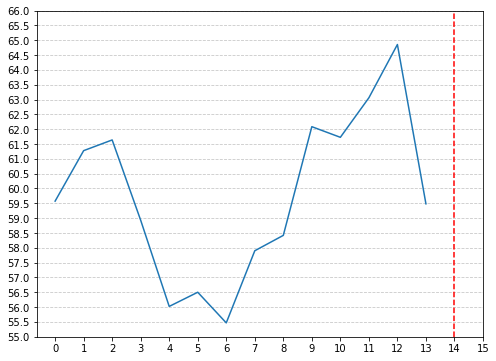

[59.57370921 61.27673894 61.63793357 58.92808123 56.02186278 56.50028203
 55.46668223 57.89983687 58.41871944 62.08541029 61.72659585 63.06010026
 64.85714771 59.48326179]
[59.23869672]




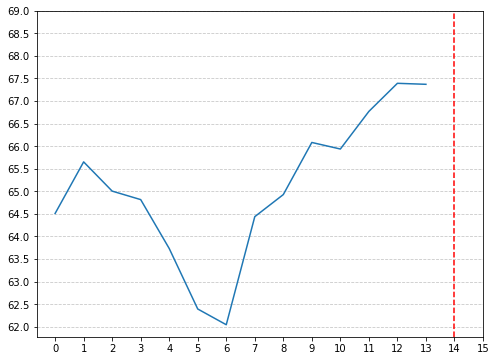

[64.507259   65.64975274 65.00233962 64.81430419 63.73131533 62.39126538
 62.04256677 64.43644819 64.92557832 66.07997304 65.93478113 66.76784948
 67.39027055 67.36825374]
[66.87198302]




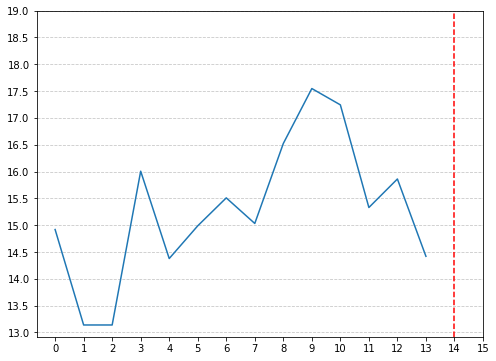

[14.91827026 13.13847923 13.13847923 16.00601951 14.37737088 14.98729593
 15.5085587  15.03132954 16.52252189 17.54719596 17.24312602 15.32885395
 15.8608276  14.4190243 ]
[14.18219487]




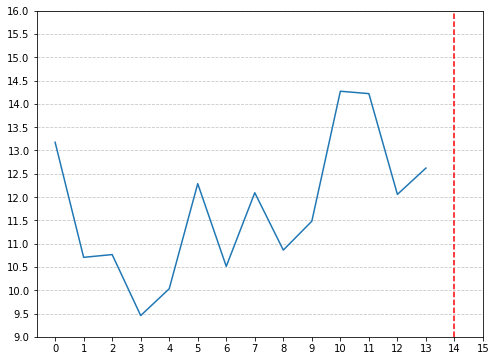

[13.17537226 10.70532459 10.76482948  9.45572206 10.03053923 12.28636932
 10.51193373 12.09178835 10.86122739 11.48067321 14.27026209 14.2190879
 12.05608542 12.6213818 ]
[12.79513606]




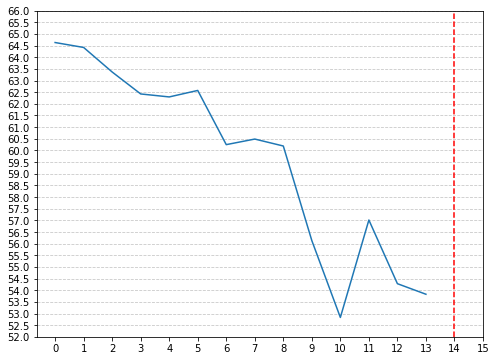

[64.63102916 64.41978682 63.36595536 62.42399307 62.29605757 62.57454042
 60.24849457 60.4877042  60.18958474 56.12897157 52.83061594 57.01321412
 54.28015487 53.82672767]
[55.9611678]


[150.5, 18.3, 93.1, 21.1, 168.4, 59.4, 55.1, 10.9, 62.6, 71.8, 63.0, 139.5, 101.0, 39.4, 116.0, 171.7, 17.2, 85.5, 19.8, 85.0, 56.0, 67.4, 13.7, 13.0, 53.4]
[146.55259075504975, 18.90033698805242, 90.15862367441603, 20.658706260867927, 170.54436426119153, 58.37706602261328, 54.31228751073415, 10.987972784794207, 62.38352974981022, 71.1854919438837, 61.39693880079899, 136.55755567028416, 99.6365613317445, 38.982639725193216, 117.14051751757914, 167.38525005835655, 15.334209390088473, 80.326036918408, 19.657239091274526, 84.22539185741311, 59.23869671873406, 66.87198302387029, 14.182194868203258, 12.795136061119331, 55.961167800064715]


In [84]:
brain_predictions = []
groundtruth = []

indices = random.sample(range(len(features_norm)), 25)

for index in indices:
    sample = denormalize(features_norm[index], minmax_scaler)
    label = denormalize(labels_norm[index], minmax_scaler)
    plt.figure(figsize=(8, 6))
    plt.plot(sample)
    plt.xticks(np.arange(len(sample) + 2))
    min_y = np.floor(min(sample))
    max_y = np.ceil(max(sample))
    yticks = np.arange(min_y, max_y + 1, step=1)
    plt.yticks(yticks)

    # Add horizontal grid lines at whole and half steps
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.yticks(np.arange(min_y, max_y + 1.5, step=0.5))
    plt.axvline(x=14, color='red', linestyle='--', label='x=14')
    plt.show()
    print(sample)
    brain_prediction = input("Your prediction for x=14: ")
    brain_predictions.append(float(brain_prediction))
    groundtruth.append(label[0])
    print(label)
    print("\n")

print(brain_predictions)
print(groundtruth)

In [85]:
brain_predictions = np.array(brain_predictions)
groundtruth = np.array(groundtruth)

mae, mape = eval(brain_predictions, groundtruth)

print(f"MAE: {round(mae, 3)}")
print(f"MAPE: {round(mape, 3)}%")

MAE: 1.582
MAPE: 2.583%
